In [0]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GRU
import numpy as np
import re

In [0]:
def convert(text):
    processed = text.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddr')
    # Replace urls with 'webaddress'
    processed = processed.str.replace(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', 'webaddress')
    processed = processed.str.replace(r'<[^>]+>', ' ')
    # Replace email addresses with 'emailaddr'
# Replace money symblos with 'moneysymb'
    processed = processed.str.replace(r'£|\$', 'moneysymb')
# Replace 10 digit phone numbers with 'phonenumber'
    processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]]{3}[\s-]?[\d]{4}$','phonenumber')
# Replace normal numbers with 'numbr'
    processed = processed.str.replace(r'\d+(\.\d+)?','numbr')
# Replace punctuation
    processed = processed.str.replace(r'[^\w\d\s]',' ')
# Replace whitespace between terms with a single space
    processed = processed.str.replace(r'\s+', ' ')
# Remove Leading and Trailing whitespaces
    processed = processed.str.replace(r'^\s+|\s+?$', '')
# Change words to lower case - Hello, HEllo, hello are all same word!
    processed = processed.str.lower()
    return (processed)

In [0]:
def convertS(text):
    # Replace email addresses with 'emailaddr'
    processed = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', 'webaddress', text)
    processed = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddr', processed)
    processed = re.sub(r'<[^>]+>', ' ', processed)
    # Replace email addresses with 'emailaddr'

    # Replace urls with 'webaddress'
    # Replace money symblos with 'moneysymb'
    processed = re.sub(r'£|\$', 'moneysymb',processed)
    # Replace 10 digit phone numbers with 'phonenumber'
    processed = re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]]{3}[\s-]?[\d]{4}$', 'phonenumber',processed)
    # Replace normal numbers with 'numbr'
    processed = re.sub(r'\d+(\.\d+)?', 'numbr',processed)
    # Replace punctuation
    processed = re.sub(r'[^\w\d\s]', ' ',processed)
    # Replace whitespace between terms with a single space
    processed = re.sub(r'\s+', ' ',processed)
    # Remove Leading and Trailing whitespaces
    processed = re.sub(r'^\s+|\s+?$', '',processed)
    # Change words to lower case - Hello, HEllo, hello are all same word!
    processed = processed.lower()
    return (processed)

In [4]:
tokenizer = Tokenizer()
laenge_pads = 57
anz_woerter = 1000000
# saved_modelLSTM = load_model('best_modelLSTM.h5')
# saved_modelGRU = load_model('best_modelGRU.h5')

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=anz_woerter+1, output_dim=50, input_length=laenge_pads))
lstm_model.add(LSTM(200, return_sequences = True))
lstm_model.add(LSTM(200, return_sequences = True))
lstm_model.add(LSTM(200))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

GRU_model = Sequential()
GRU_model.add(Embedding(input_dim=anz_woerter + 1, output_dim=57, input_length=laenge_pads))
GRU_model.add(GRU(200, return_sequences = True))
GRU_model.add(GRU(200, return_sequences = True))
GRU_model.add(GRU(200))
GRU_model.add(Dense(1, activation='sigmoid'))

GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
GRU_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 57, 50)            50000050  
_________________________________________________________________
lstm (LSTM)                  (None, 57, 200)           200800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 57, 200)           320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 50,842,651
Trainable params: 50,842,651
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)          

In [5]:
global df, saved_modelGRU, saved_modelLSTM
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/last_data.xlsx')
print(df.columns)
df.drop(['Density'], axis = 1,inplace = True)
print('!!!!!!!')
print(df.shape)
df.dropna(inplace = True)
print(df.shape)
df["Message"] = convert(df["Message"])
df['Message'] = df['Message'].astype(str)
#     df['isFriend'] = df['isFriend'].astype(int)
#     df['Friends'] = df['Friends'].astype(int)
#     df['Followers'] = df['Followers'].astype(int)
#     df['RelationRatio'] = df['RelationRatio'].astype(int)
#     df['PageAge'] = df['PageAge'].astype(int)
#     print(df.head())
#     print(df.tail())
df['target'] = df['isSpam'].map({True: 1, False: 0})
df['isFriend'] = df['isFriend'].map({True: 1, False: 0})
df['isBlocked'] = df['isBlocked'].map({True: 1, False: 0})
df['len'] = df['Message'].apply(len)
## b) Trainings- und Testdaten separieren
df_train = df.sample(frac=.7, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

y_train = df_train['target'].values
y_test = df_test['target'].values
y_test.shape

X_train = df_train['Message'].values
X_test = df_test['Message'].values
df_train.drop(['Message', 'isSpam', 'target', 'URL'], axis = 1, inplace = True)
df_test.drop(['Message', 'isSpam', 'target', 'URL'], axis = 1 ,inplace = True)
df_train.info()
df_test.info()

#     print(X_train)
tokenizer.fit_on_texts(X_train)
word_dict = tokenizer.index_word
print(len(word_dict.keys()))
#print(len(word_dict))
#print(word_dict)

#for key in word_dict.keys():
#    print(key, word_dic
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print(X_train_seq[:5])
print(df_train.iloc[0,:])
for el in X_train_seq[0]:
    print(word_dict[el], end=' ')

X_train_pad = pad_sequences(X_train_seq, maxlen=50, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=50, padding='post')
X_train_pad[:5]
X_train_pad.shape
print(X_train_pad[:5])
X_train_pad = np.hstack(( X_train_pad, df_train))
X_test_pad = np.hstack((X_test_pad, df_test))
X_train_pad = np.asarray(X_train_pad)
X_test_pad = np.asarray(X_test_pad)

print('!!!!!')
print(X_train_pad.shape, X_test_pad.shape)

es_LSTM = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc_LSTM = ModelCheckpoint('best_modelLSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history1 = lstm_model.fit(X_train_pad, y_train, epochs=15, verbose=1,
                        validation_data=(X_test_pad, y_test), callbacks=[es_LSTM, mc_LSTM])
saved_modelLSTM = load_model('best_modelLSTM.h5')
_, train_acc = lstm_model.evaluate(X_train_pad, y_train, verbose=0)
_, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)

_, train_acc_S = saved_modelLSTM.evaluate(X_train_pad, y_train, verbose=0)
_, test_acc_S = saved_modelLSTM.evaluate(X_test_pad, y_test, verbose=0)
print('LSTM:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Train: %.3f, Test: %.3f' % (train_acc_S, test_acc_S))
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
# pyplot.close()

es_GRU = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc_GRU = ModelCheckpoint('best_modelGRU.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history2 = GRU_model.fit(X_train_pad, y_train, epochs=15, verbose=1,
                         validation_data=(X_test_pad, y_test), callbacks=[es_GRU, mc_GRU])
saved_modelGRU = load_model('best_modelGRU.h5')
_, train_acc = GRU_model.evaluate(X_train_pad, y_train, verbose=0)
_, test_acc = GRU_model.evaluate(X_test_pad, y_test, verbose=0)

_, train_acc_S = saved_modelGRU.evaluate(X_train_pad, y_train, verbose=0)
_, test_acc_S = saved_modelGRU.evaluate(X_test_pad, y_test, verbose=0)
print('GRU:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Train: %.3f, Test: %.3f' % (train_acc_S, test_acc_S))
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
# pyplot.close()
return history1, history2, X_test_pad, y_test

Index(['Message', 'URL', 'isFriend', 'Friends', 'Followers', 'RelationRatio',
       'PageAge', 'Density', 'isSpam', 'isBlocked'],
      dtype='object')
!!!!!!!
(1011, 9)
(998, 9)
(699, 11) (299, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 25 to 582
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   isFriend       699 non-null    int64  
 1   Friends        699 non-null    float64
 2   Followers      699 non-null    float64
 3   RelationRatio  699 non-null    float64
 4   PageAge        699 non-null    float64
 5   isBlocked      699 non-null    int64  
 6   len            699 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 43.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 996
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   isFriend       299 non-null    int64  
 1   Friends

SyntaxError: ignored

In [0]:
import matplotlib.pyplot as plt

In [0]:
import pickle
with open('./tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

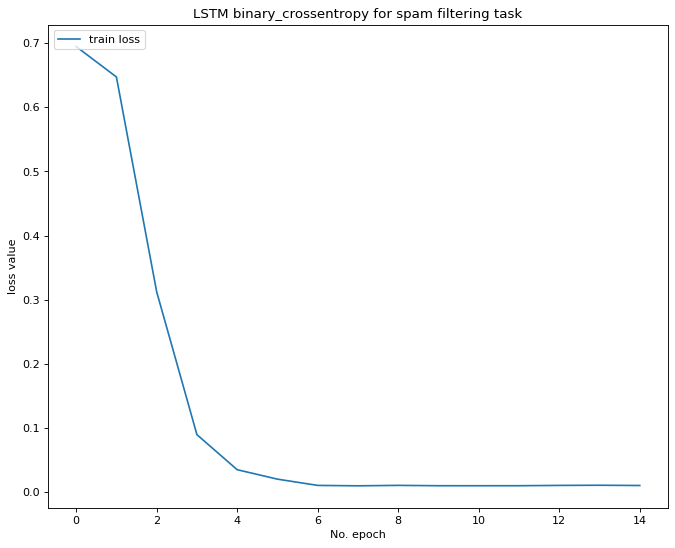

In [55]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history1.history['loss'], label='train loss')
#plt.plot(history1.history['val_loss'], label='val loss')
plt.title('LSTM binary_crossentropy for spam filtering task')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

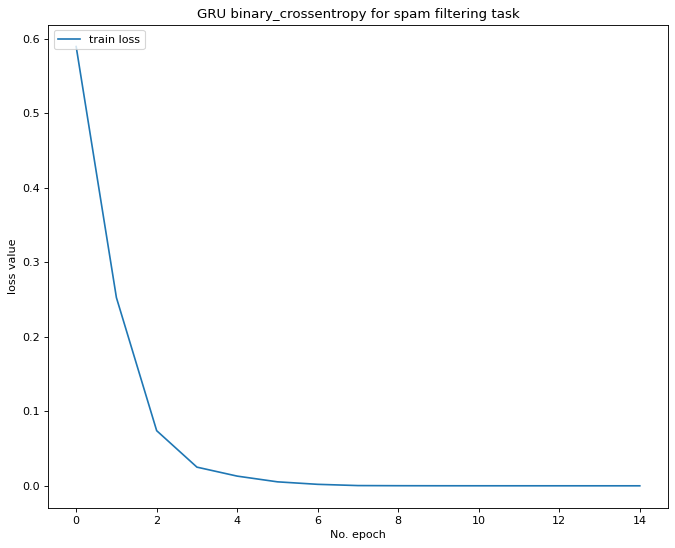

In [51]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history2.history['loss'], label='train loss')
#plt.plot(history2.history['val_loss'], label='val loss')
plt.title('GRU binary_crossentropy for spam filtering task')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [43]:
!pip install scikit-plot

In [0]:
import sklearn
from sklearn import metrics

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [47]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

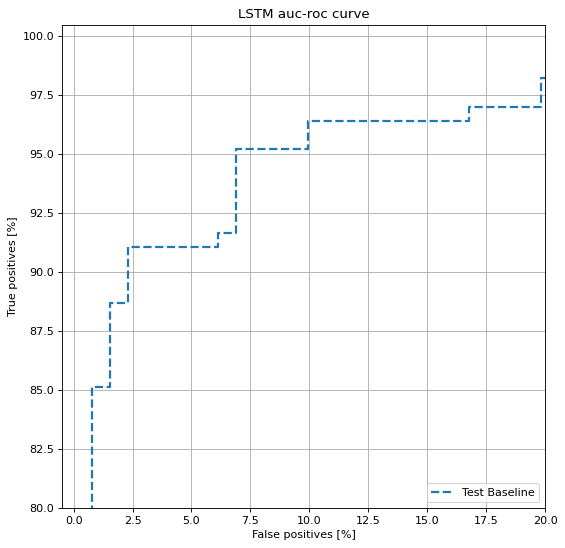

In [48]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, y_probas, color=colors[0], linestyle='--')
plt.title('LSTM auc-roc curve')
plt.legend(loc='lower right')


In [0]:
y_probas =  saved_modelGRU(X_test_pad)

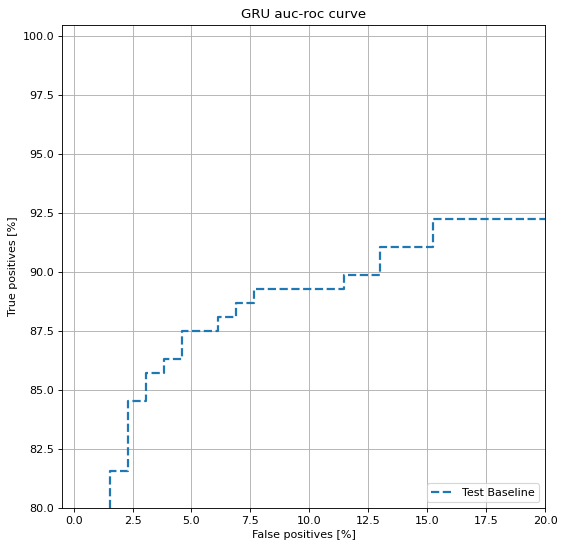

In [50]:
plot_roc("Test Baseline", y_test, y_probas, color=colors[0], linestyle='--')
plt.title('GRU auc-roc curve')
plt.legend(loc='lower right')